## Effect of Image Size on Training

We Previously determined that the ADAM optimizer gave us the best results with a batch size of 256, and a learning rate of 0.0005. and with a gradient accumulation step size of 8 or batch size of 256. We will now try a variety of image sizes to determine if, as we might expect, that the full size images provide the best model.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)

Scans found: 112120 , Total Headers 112120
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [6]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [7]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [8]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

# Tuning Image Size

In [1]:
# Gradient Accumulation Borrowed from following location:
# https://stackoverflow.com/questions/55268762/how-to-accumulate-gradients-for-large-batch-sizes-in-keras

import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer

class AdamAccumulate(Optimizer):

    def __init__(self, lr=0.005, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
        if accum_iters < 1:
            raise ValueError('accum_iters must be >= 1')
        super(AdamAccumulate, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
        self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        completed_updates = K.cast(K.tf.floordiv(self.iterations, self.accum_iters), K.floatx())

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * completed_updates))

        t = completed_updates + 1

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        # self.iterations incremented after processing a batch
        # batch:              1 2 3 4 5 6 7 8 9
        # self.iterations:    0 1 2 3 4 5 6 7 8
        # update_switch = 1:        x       x    (if accum_iters=4)  
        update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
        update_switch = K.cast(update_switch, K.floatx())

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]

        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

            sum_grad = tg + g
            avg_grad = sum_grad / self.accum_iters_float

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
            self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
            self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulate, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [24]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers

def MakeModel(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

### Here we set the steps per epoch and the batch size so regardless of learning rate, we are looking at the same number of examples

In [37]:
IMG_SIZE_LIST = [(1024, 1024), (512, 512), (256, 256), (224, 224), (192,192) ,(128, 128), (64, 64)]
BATCH_SIZE_LIST = [4, 8, 16, 32, 32, 32, 64]

#This was determined earlier in the training data loader
STEPS_PER_EPOCH = 10000
EPOCHS = 10

In [ ]:
import gc
from collections import defaultdict
from sklearn.metrics import log_loss

run_this_code = True # This Code Block Takes a long time to run

if run_this_code:
    train_results = defaultdict(dict)
    test_results  = defaultdict(dict)
    
    lr = 0.0005
    syntheticBatch = 256
    
    plt.figure(figsize=(20,5))

    for imageSize, batchSize in zip(IMG_SIZE_LIST, BATCH_SIZE_LIST): #Number of batches before gradient accumulation
        
        batch = int(256 / batchSize) # Gradient Accumulation Step
        
        train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize)

        valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize) # we can use much larger batches for evaluation

        print ('Running Image Size: ', imageSize, 'Running Batch size : ', 
               batchSize, 'Learning Rate : ', lr)
        
        predictions_train = pd.DataFrame()
        predictions_test  = pd.DataFrame()

        opt = AdamAccumulate(lr=lr, accum_iters=batch) #Set the gradient accumulation value
        
        multi_disease_model = MakeModel(imageSize, batchSize)
        multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
               metrics = ['binary_accuracy', 'mae'])

        history = multi_disease_model.fit_generator(train_gen, 
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data = valid_gen, 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      validation_steps = 1000)

        #multi_disease_model.load_weights(weight_path)
    
        plt.plot(history.history['val_loss'])

        p = history.history['val_loss'][0]

        del multi_disease_model, history
        gc.collect()
        print('*'*50)
        print('')

        test_results[imageSize[0]][lr]  = p
        imageSizeFile = pd.DataFrame(test_results)
        imageSizeFile.to_csv("imageSize.csv", index=True)

    plt.legend([str(x[0]) for x in IMG_SIZE_LIST], loc='upper right')
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.savefig('image_size_selection.png', bbox_inches='tight')

Found 28286 validated image filenames belonging to 13 classes.
Found 9430 validated image filenames belonging to 13 classes.
Running Image Size:  (1024, 1024) Running Batch size :  4 Learning Rate :  0.0005
Epoch 1/10
10000/10000 [==============================] - 3926s 393ms/step - loss: 0.3675 - binary_accuracy: 0.8597 - mean_absolute_error: 0.2104 - val_loss: 0.3338 - val_binary_accuracy: 0.8702 - val_mean_absolute_error: 0.2003

Epoch 00001: val_loss did not improve from 0.31454
Epoch 2/10
10000/10000 [==============================] - 4014s 401ms/step - loss: 0.3462 - binary_accuracy: 0.8669 - mean_absolute_error: 0.2055 - val_loss: 0.3321 - val_binary_accuracy: 0.8695 - val_mean_absolute_error: 0.1984

Epoch 00002: val_loss did not improve from 0.31454
Epoch 3/10
10000/10000 [==============================] - 3965s 397ms/step - loss: 0.3426 - binary_accuracy: 0.8675 - mean_absolute_error: 0.2040 - val_loss: 0.3290 - val_binary_accuracy: 0.8706 - val_mean_absolute_error: 0.1969

E

### Power Outage Occured during training of 192 x 192 image size.  We will continue for the last 3 image sizes

Found 28261 validated image filenames belonging to 13 classes.
Found 9420 validated image filenames belonging to 13 classes.
Running Image Size:  (192, 192) Running Batch size :  64 Learning Rate :  0.0005
Epoch 1/10
2000/2000 [==============================] - 1868s 934ms/step - loss: 0.3561 - binary_accuracy: 0.8634 - mean_absolute_error: 0.2041 - val_loss: 0.3303 - val_binary_accuracy: 0.8700 - val_mean_absolute_error: 0.1940

Epoch 00001: val_loss improved from inf to 0.33029, saving model to xray_class_weights.best.hdf5
Epoch 2/10
2000/2000 [==============================] - 1915s 957ms/step - loss: 0.3325 - binary_accuracy: 0.8704 - mean_absolute_error: 0.1976 - val_loss: 0.3273 - val_binary_accuracy: 0.8714 - val_mean_absolute_error: 0.1895

Epoch 00002: val_loss improved from 0.33029 to 0.32734, saving model to xray_class_weights.best.hdf5
Epoch 3/10
2000/2000 [==============================] - 1885s 942ms/step - loss: 0.3239 - binary_accuracy: 0.8724 - mean_absolute_error: 0.1


Epoch 00006: val_loss did not improve from 0.30110
Epoch 7/10
2000/2000 [==============================] - 2863s 1s/step - loss: 0.3042 - binary_accuracy: 0.8775 - mean_absolute_error: 0.1830 - val_loss: 0.3155 - val_binary_accuracy: 0.8755 - val_mean_absolute_error: 0.1838

Epoch 00007: val_loss did not improve from 0.30110
Epoch 8/10
2000/2000 [==============================] - 2900s 1s/step - loss: 0.2979 - binary_accuracy: 0.8794 - mean_absolute_error: 0.1794 - val_loss: 0.3117 - val_binary_accuracy: 0.8757 - val_mean_absolute_error: 0.1805

Epoch 00008: val_loss did not improve from 0.30110
Epoch 9/10
2000/2000 [==============================] - 2875s 1s/step - loss: 0.2901 - binary_accuracy: 0.8820 - mean_absolute_error: 0.1748 - val_loss: 0.3186 - val_binary_accuracy: 0.8730 - val_mean_absolute_error: 0.1812

Epoch 00009: val_loss did not improve from 0.30110
Epoch 10/10
2000/2000 [==============================] - 2901s 1s/step - loss: 0.2811 - binary_accuracy: 0.8849 - mean_a

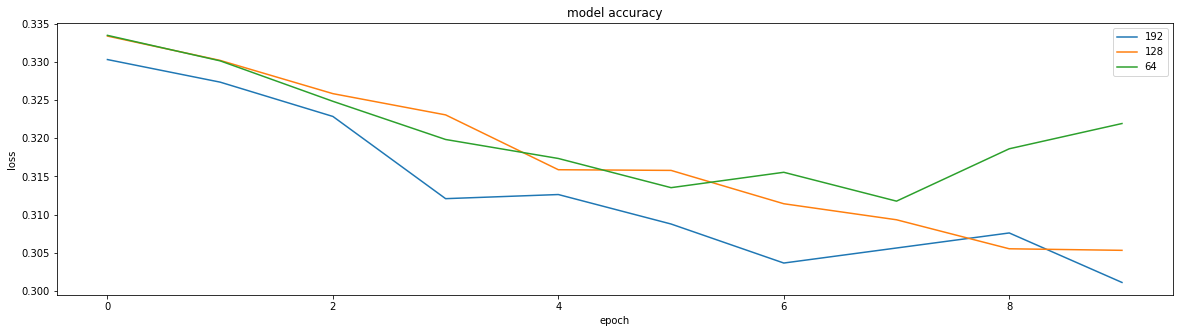

<Figure size 432x288 with 0 Axes>

In [14]:
IMG_SIZE_LIST = [(192,192) ,(128, 128), (64, 64)]
BATCH_SIZE_LIST = [64, 64, 128]

#This was determined earlier in the training data loader
STEPS_PER_EPOCH = 2000
EPOCHS = 10

import gc
from collections import defaultdict
from sklearn.metrics import log_loss

run_this_code = True # This Code Block Takes a long time to run

if run_this_code:
    train_results = defaultdict(dict)
    test_results  = defaultdict(dict)
    
    lr = 0.0005
    syntheticBatch = 256
    
    plt.figure(figsize=(20,5))

    for imageSize, batchSize in zip(IMG_SIZE_LIST, BATCH_SIZE_LIST): #Number of batches before gradient accumulation
        
        batch = int(256 / batchSize) # Gradient Accumulation Step
        
        train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize)

        valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize) # we can use much larger batches for evaluation

        print ('Running Image Size: ', imageSize, 'Running Batch size : ', 
               batchSize, 'Learning Rate : ', lr)
        
        predictions_train = pd.DataFrame()
        predictions_test  = pd.DataFrame()

        opt = AdamAccumulate(lr=lr, accum_iters=batch) #Set the gradient accumulation value
        
        multi_disease_model = MakeModel(imageSize, batchSize)
        multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
               metrics = ['binary_accuracy', 'mae'])

        history = multi_disease_model.fit_generator(train_gen, 
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data = valid_gen, 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      validation_steps = int(9000/batchSize))

        #multi_disease_model.load_weights(weight_path)
    
        plt.plot(history.history['val_loss'])

        p = history.history['val_loss'][0]

        del multi_disease_model, history
        gc.collect()
        print('*'*50)
        print('')

        test_results[imageSize[0]][lr]  = p
        imageSizeFile = pd.DataFrame(test_results)
        imageSizeFile.to_csv("imageSize.csv", index=True)

    plt.legend([str(x[0]) for x in IMG_SIZE_LIST], loc='upper right')
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.savefig('image_size_selection.png', bbox_inches='tight')

In [16]:
# Manually plot validation_loss as the computer lost power

image_size_results = defaultdict(dict)

#pd_epochs_list = [i for i in range(10)]

image_size_results[1024] = [0.3338, 0.3321, 0.3290, 0.3273, 0.3259, 0.3191, 0.3193, 0.3179, 0.3145, 0.3173]
image_size_results[512] = [0.3277, 0.3209, 0.3161, 0.3116, 0.3049, 0.3045, 0.2978, 0.2966, 0.2934, 0.2916]
image_size_results[256] = [0.3255, 0.3174, 0.3066, 0.3006, 0.2996, 0.2952, 0.2951, 0.2917, 0.2905, 0.2933]
image_size_results[224] = [0.3168, 0.3048, 0.2982, 0.2966, 0.3034, 0.3021, 0.3275, 0.3386, 0.3624, None]
image_size_results[192] = [0.3303, 0.3273, 0.3228, 0.3121, 0.3126, 0.3088, 0.3036, 0.3056, 0.3076, 0.3011]
image_size_results[128] = [0.3334, 0.3302, 0.3258, 0.3230, 0.3159, 0.3158, 0.3114, 0.3093, 0.3055, 0.3053]
image_size_results[64] = [0.3335, 0.3301, 0.3248, 0.3198, 0.3173, 0.3135, 0.3155, 0.3117, 0.3186, 0.3219]

imageSizeDF = pd.DataFrame(image_size_results)

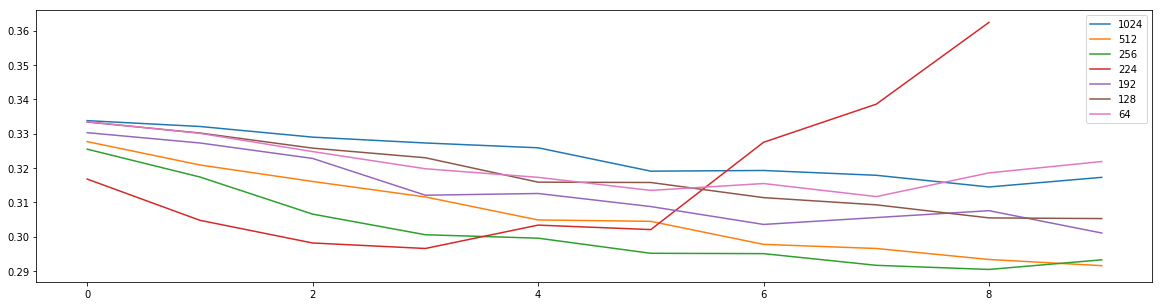

In [17]:
plt.figure(figsize=(20,5))
plt.plot(imageSizeDF)
plt.legend([x for x in imageSizeDF.columns])

In [18]:
imageSizeDF

,1024,512,256,224,192,128,64
0,0.3338,0.3277,0.3255,0.3168,0.3303,0.3334,0.3335
1,0.3321,0.3209,0.3174,0.3048,0.3273,0.3302,0.3301
2,0.3290,0.3161,0.3066,0.2982,0.3228,0.3258,0.3248
3,0.3273,0.3116,0.3006,0.2966,0.3121,0.3230,0.3198
4,0.3259,0.3049,0.2996,0.3034,0.3126,0.3159,0.3173
5,0.3191,0.3045,0.2952,0.3021,0.3088,0.3158,0.3135
6,0.3193,0.2978,0.2951,0.3275,0.3036,0.3114,0.3155
7,0.3179,0.2966,0.2917,0.3386,0.3056,0.3093,0.3117
8,0.3145,0.2934,0.2905,0.3624,0.3076,0.3055,0.3186
9,0.3173,0.2916,0.2933,NaN,0.3011,0.3053,0.3219


#### Analysis of Image Size:

The above table shows image size resolution.  Mobile net was designed for 224 x 224. VGG19 was also designed with a native resolution of 224 x 224.  However, inceptionV3 resnet was designed with a resolution of 299 x 299.  We might expect no improvement in performance beyond the initial design of the network.  However, we do in fact see some improvement with images of size 512 x 512.  Therefore, we will go forward with a resolution of 512 x 512, knowing with confidence that we should get results at least as good as using the native resolution of the various models (299 x 299).



#### Hyper-Parameter Tuning:

Going forward we can use the ADAM optimizer along with a batch size of 256 using gradient accumulation every 8th step with an actual batch size of 32.

We can use image size of (512 x 512)

# RGB vs Black and White and Compare Most Promising Resolutions 

Found 28261 validated image filenames belonging to 13 classes.
Found 9420 validated image filenames belonging to 13 classes.
Running Image Size:  (256, 256) Running Batch size :  32 Learning Rate :  0.0005 Color Mode :  rgb
Epoch 1/10
1000/1000 [==============================] - 1300s 1s/step - loss: 0.3883 - binary_accuracy: 0.8547 - mean_absolute_error: 0.2090 - val_loss: 0.3385 - val_binary_accuracy: 0.8668 - val_mean_absolute_error: 0.1990

Epoch 00001: val_loss did not improve from 0.30110
Epoch 2/10
1000/1000 [==============================] - 1327s 1s/step - loss: 0.3471 - binary_accuracy: 0.8662 - mean_absolute_error: 0.2038 - val_loss: 0.3339 - val_binary_accuracy: 0.8687 - val_mean_absolute_error: 0.2016

Epoch 00002: val_loss did not improve from 0.30110
Epoch 3/10
1000/1000 [==============================] - 1348s 1s/step - loss: 0.3419 - binary_accuracy: 0.8674 - mean_absolute_error: 0.2021 - val_loss: 0.3329 - val_binary_accuracy: 0.8680 - val_mean_absolute_error: 0.1925



Epoch 00007: val_loss did not improve from 0.30110
Epoch 8/10
1000/1000 [==============================] - 741s 741ms/step - loss: 0.3273 - binary_accuracy: 0.8714 - mean_absolute_error: 0.1954 - val_loss: 0.3258 - val_binary_accuracy: 0.8720 - val_mean_absolute_error: 0.1822

Epoch 00008: val_loss did not improve from 0.30110
Epoch 9/10
1000/1000 [==============================] - 739s 739ms/step - loss: 0.3253 - binary_accuracy: 0.8722 - mean_absolute_error: 0.1939 - val_loss: 0.3191 - val_binary_accuracy: 0.8743 - val_mean_absolute_error: 0.1897

Epoch 00009: val_loss did not improve from 0.30110
Epoch 10/10
1000/1000 [==============================] - 744s 744ms/step - loss: 0.3223 - binary_accuracy: 0.8729 - mean_absolute_error: 0.1928 - val_loss: 0.3189 - val_binary_accuracy: 0.8741 - val_mean_absolute_error: 0.1914

Epoch 00010: val_loss did not improve from 0.30110
**************************************************

Found 28261 validated image filenames belonging to 13 classes

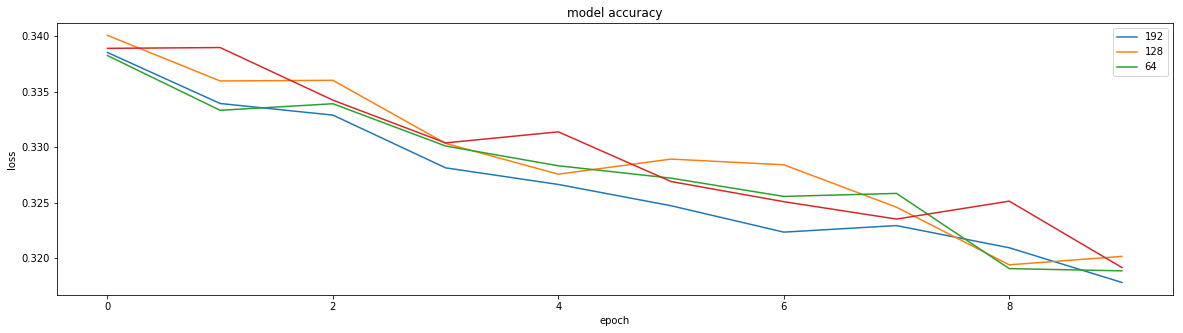

<Figure size 432x288 with 0 Axes>

In [30]:
COLOR_MODE_LIST = ['rgb', 'grayscale']
BATCH_SIZE = 32
IMAGE_SIZE_LIST = [(256,256) ,(224, 224)]
CHANNEL_LIST = [3, 1]

#This was determined earlier in the training data loader
STEPS_PER_EPOCH = 1000
EPOCHS = 10

import gc
from collections import defaultdict
from sklearn.metrics import log_loss

run_this_code = True # This Code Block Takes a long time to run

if run_this_code:
    train_results = defaultdict(dict)
    test_results  = defaultdict(dict)
    
    lr = 0.0005
    syntheticBatch = 256
    
    plt.figure(figsize=(20,5))

    for channels, colorMode in zip(CHANNEL_LIST, COLOR_MODE_LIST): #Number of batches before gradient accumulation
        for imageSize in IMAGE_SIZE_LIST:

            batch = int(256 / BATCH_SIZE) # Gradient Accumulation Step

            train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                                     directory=None,
                                     x_col = 'path',
                                    y_col = 'newLabel', 
                                     class_mode = 'categorical',
                                    classes = all_labels,
                                    target_size = imageSize,
                                     color_mode = colorMode,
                                    batch_size = BATCH_SIZE)

            valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                                     directory=None,
                                     x_col = 'path',
                                    y_col = 'newLabel', 
                                     class_mode = 'categorical',
                                    classes = all_labels,
                                    target_size = imageSize,
                                     color_mode = colorMode,
                                    batch_size = BATCH_SIZE)

            print ('Running Image Size: ', imageSize, 'Running Batch size : ', 
                   BATCH_SIZE, 'Learning Rate : ', lr, 'Color Mode : ', colorMode)

            predictions_train = pd.DataFrame()
            predictions_test  = pd.DataFrame()

            opt = AdamAccumulate(lr=lr, accum_iters=batch) #Set the gradient accumulation value

            multi_disease_model = MakeModel(imageSize, batchSize, channels)
            multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy', 'mae'])

            history = multi_disease_model.fit_generator(train_gen, 
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = valid_gen, 
                          epochs = EPOCHS, 
                          callbacks = callbacks_list,
                          validation_steps = int(9000/BATCH_SIZE))

            #multi_disease_model.load_weights(weight_path)

            plt.plot(history.history['val_loss'])

            p = history.history['val_loss'][0]

            del multi_disease_model, history
            gc.collect()
            print('*'*50)
            print('')

            test_results[imageSize[0]][colorMode]  = p
            imageSizeFile = pd.DataFrame(test_results)
            imageSizeFile.to_csv("imageSize.csv", index=True)

    plt.legend([str(x[0]) for x in IMG_SIZE_LIST], loc='upper right')
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.savefig('image_size_selection.png', bbox_inches='tight')

In [31]:
test_results

defaultdict(dict,
            {256: {'rgb': 0.33851325384662667,
              'grayscale': 0.3382359535244436},
             224: {'rgb': 0.34005365571093304,
              'grayscale': 0.33888346603756697}})

# Create Preliminary Mobile Net Model with Selected Parameters

In [34]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 16
batch = 256 / batchSize
STEPS_PER_EPOCH = 1000
EPOCHS = 100

train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation


opt = AdamAccumulate(lr=lr, accum_iters=int(batch)) #Set the gradient accumulation value
multi_disease_model = MakeModel(imageSize, batchSize, channels)
multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
       metrics = ['binary_accuracy', 'mae'])

history = multi_disease_model.fit_generator(train_gen, 
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data = valid_gen, 
              epochs = EPOCHS, 
              callbacks = callbacks_list,
              validation_steps = int(9000/BATCH_SIZE))

Found 28261 validated image filenames belonging to 13 classes.
Found 9420 validated image filenames belonging to 13 classes.
Epoch 1/100
1000/1000 [==============================] - 1654s 2s/step - loss: 0.4004 - binary_accuracy: 0.8505 - mean_absolute_error: 0.2118 - val_loss: 0.3442 - val_binary_accuracy: 0.8662 - val_mean_absolute_error: 0.1957

Epoch 00001: val_loss did not improve from 0.30110
Epoch 2/100
1000/1000 [==============================] - 1593s 2s/step - loss: 0.3534 - binary_accuracy: 0.8637 - mean_absolute_error: 0.2064 - val_loss: 0.3352 - val_binary_accuracy: 0.8685 - val_mean_absolute_error: 0.1973

Epoch 00002: val_loss did not improve from 0.30110
Epoch 3/100
1000/1000 [==============================] - 1599s 2s/step - loss: 0.3457 - binary_accuracy: 0.8677 - mean_absolute_error: 0.2034 - val_loss: 0.3366 - val_binary_accuracy: 0.8699 - val_mean_absolute_error: 0.1978

Epoch 00003: val_loss did not improve from 0.30110
Epoch 4/100
1000/1000 [=====================

1000/1000 [==============================] - 1597s 2s/step - loss: 0.3062 - binary_accuracy: 0.8780 - mean_absolute_error: 0.1835 - val_loss: 0.3054 - val_binary_accuracy: 0.8795 - val_mean_absolute_error: 0.1768

Epoch 00030: val_loss did not improve from 0.30110
Epoch 31/100
1000/1000 [==============================] - 1593s 2s/step - loss: 0.3063 - binary_accuracy: 0.8772 - mean_absolute_error: 0.1837 - val_loss: 0.3041 - val_binary_accuracy: 0.8784 - val_mean_absolute_error: 0.1837

Epoch 00031: val_loss did not improve from 0.30110
Epoch 32/100
1000/1000 [==============================] - 1601s 2s/step - loss: 0.3060 - binary_accuracy: 0.8781 - mean_absolute_error: 0.1833 - val_loss: 0.3053 - val_binary_accuracy: 0.8779 - val_mean_absolute_error: 0.1822

Epoch 00032: val_loss did not improve from 0.30110
Epoch 33/100
1000/1000 [==============================] - 1600s 2s/step - loss: 0.3029 - binary_accuracy: 0.8788 - mean_absolute_error: 0.1817 - val_loss: 0.3037 - val_binary_accu

# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

In [37]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'rgb',
                        batch_size = 9403))

Found 9420 validated image filenames belonging to 13 classes.


In [38]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

9403/9403 [==============================] - 61s 6ms/step


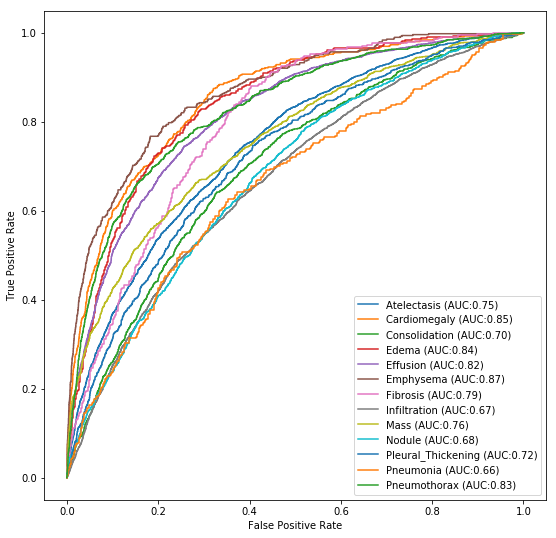

In [39]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')